In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/MOSTA'
args.max_neighbors=8
args.hvgs=2000
args.er_w=0.1
args.sigma=1
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/MOSTA', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, er_w=0.1, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=8, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2025, self_loops=True, sigma=1, weight_decay=0.0001)

In [4]:
adata = sc.read_h5ad(args.dataset_path + '/E9.5_E1S1.MOSTA.h5ad')
adata

AnnData object with n_obs × n_vars = 5913 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [5]:
adata.obs['annotation']

cell_name
147_104        Cavity
147_105        Cavity
147_106        Cavity
147_107        Cavity
147_108    Mesenchyme
              ...    
253_110        Cavity
253_111        Cavity
253_112        Cavity
253_113        Cavity
253_114        Cavity
Name: annotation, Length: 5913, dtype: category
Categories (12, object): ['AGM', 'Brain', 'Branchial arch', 'Cavity', ..., 'Mesenchyme', 'Neural crest', 'Notochord', 'Sclerotome']

In [6]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [7]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata_hvg, method='knn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

5913 2000 torch.Size([2, 54079])


In [8]:
import time
start_time = time.time()
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data, print_every=100)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:1.9578, T:0.6677, S:0.5211, D:0.7690]

Epoch 100: Train[Total:0.7443, T:0.2779, S:0.2375, D:0.2289]

Epoch 200: Train[Total:0.6006, T:0.2304, S:0.2312, D:0.1390]

Epoch 300: Train[Total:0.5148, T:0.2272, S:0.2283, D:0.0593]

Epoch 400: Train[Total:0.4820, T:0.2255, S:0.2265, D:0.0301]

Epoch 500: Train[Total:0.4648, T:0.2239, S:0.2253, D:0.0156]

Epoch 600: Train[Total:0.4555, T:0.2226, S:0.2239, D:0.0090]

Epoch 700: Train[Total:0.4510, T:0.2218, S:0.2245, D:0.0047]

Epoch 800: Train[Total:0.4461, T:0.2205, S:0.2227, D:0.0029]

Epoch 900: Train[Total:0.4470, T:0.2207, S:0.2221, D:0.0043]

Epoch 999: Train[Total:0.4429, T:0.2198, S:0.2214, D:0.0018]


In [9]:
end_time = time.time()
print(f"time: {end_time - start_time:.4f} s")

time: 36.3133 s


In [10]:
z_s, latent, attn = cps_model.interpret_attn_scores(pyg_data)
adata_hvg.obsm['z_s'] = z_s
adata_hvg.obsm['z_t'] = latent
adata_hvg.obsm['attns'] = attn
adata_hvg.obsm['attn'] = attn.reshape(adata_hvg.n_obs, 32)

In [11]:
adata_hvg

AnnData object with n_obs × n_vars = 5913 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Reg

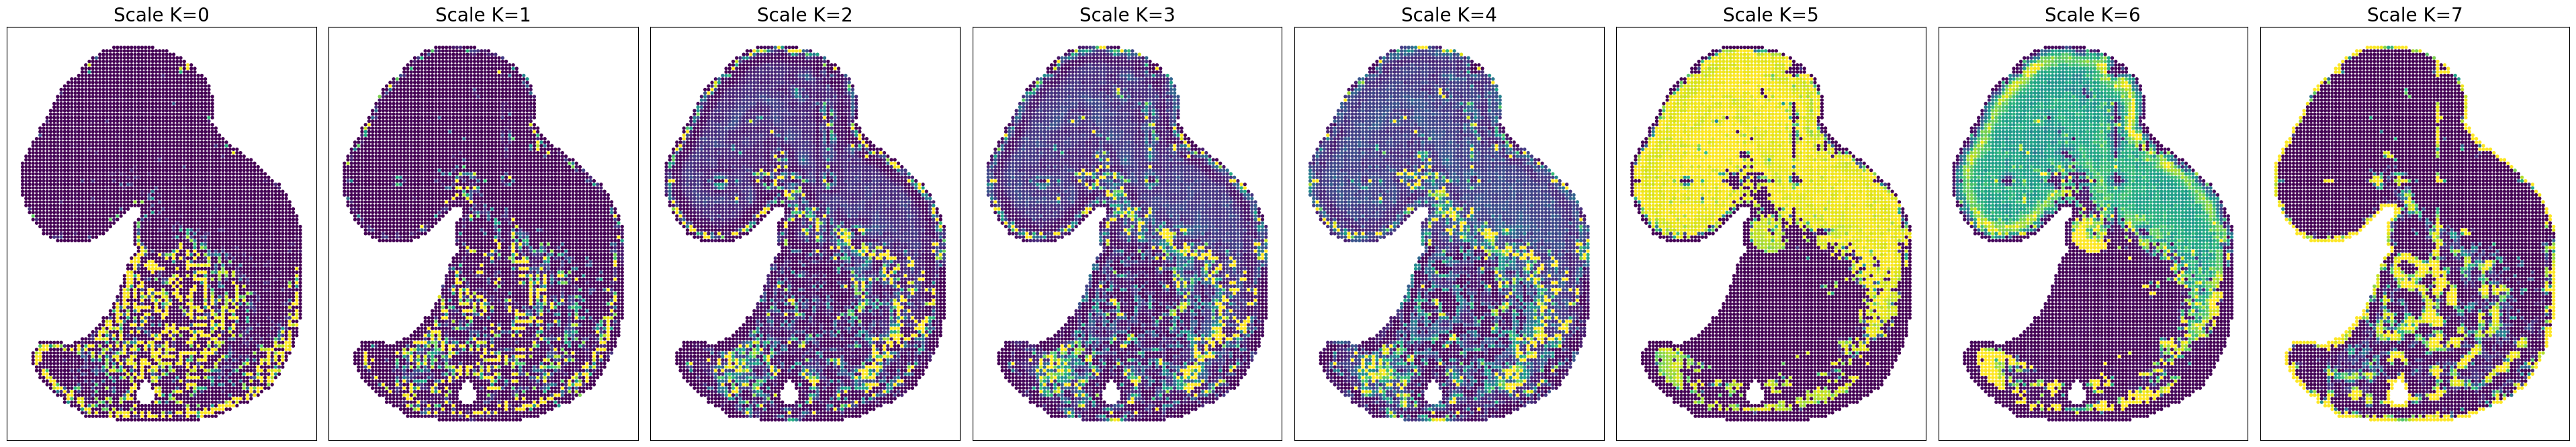

In [12]:
# show the average attention scores of multiple scales
attn_avg_heads = attn.mean(axis=-1)
for i, k in enumerate(args.k_list):
    adata_hvg.obs[f'Scale K={k}'] = attn_avg_heads[:, i]

context_params = {
    'figure.figsize': (6, 8),
    'font.size': 12,              # 全局默认字体大小
    'axes.titlesize': 20,         # 子图标题大小 (Scale K=...)
    'legend.fontsize': 10,        # 图例字体大小 (如果有)
    'axes.labelsize': 12,         # 轴标签大小
    'xtick.labelsize': 10,        # 刻度大小
    'ytick.labelsize': 10,
}

with plt.rc_context(context_params):
    axes_list = sc.pl.spatial(
        adata_hvg, 
        color=[f'Scale K={k}' for k in args.k_list],
        show=False,
        spot_size=1,
        colorbar_loc=None,
        cmap='viridis',
        ncols=8,
        vmax='p95',
        wspace=0.0, # 配合上面调整间距
    )

    if not isinstance(axes_list, list):
        axes_list = [axes_list]
    for ax in axes_list:
        ax.set_xlabel('')  # 去掉 spatial1
        ax.set_ylabel('')  # 去掉 spatial2
    plt.subplots_adjust(wspace=1, hspace=0.2)
    
    plt.show()

In [13]:
args.clusters=12
adata_hvg = CPS.mclust(adata_hvg, args, key='z_s', pca_dim=32)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


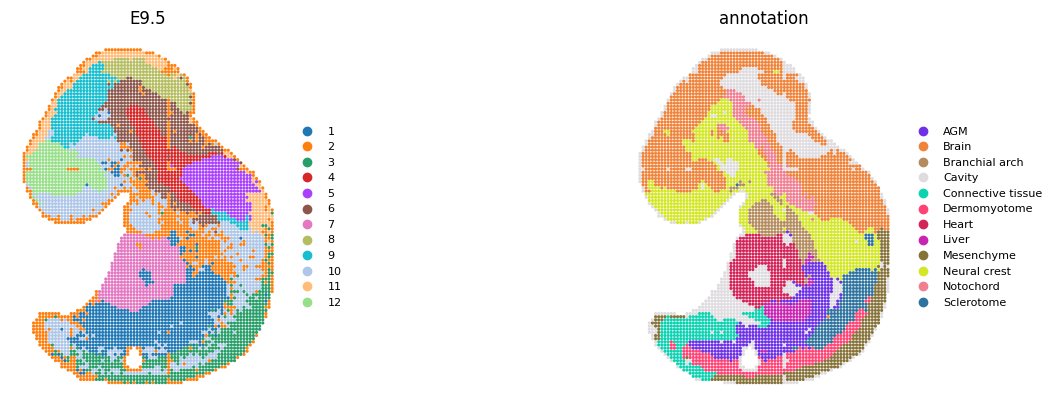

In [14]:
sc.pl.spatial(adata_hvg, img_key=None, color=['mclust','annotation'], 
              title=['E9.5'], size=1., legend_fontsize=8, 
              frameon=False, spot_size=1)